In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='once')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import datetime as dt 
from datetime import datetime, timedelta

### Chargement des données 

In [6]:
merged = pd.read_csv('../data_CROUS/data_processed/merged_one_hot/merged_Forms_Choix.csv' , sep=",", encoding='latin-1')
print(merged.columns)

Index(['Unnamed: 0', 'index', 'Genre', 'Age', 'Taille', 'Poids', 'IMC',
       'Activité physique', 'Régime particulier', 'Végé',
       ...
       'parisbrest', 'poire', 'pruneauxausirop', 'emmental',
       'bleudauvergneaop', 'cremepraline', 'gateaudesemoule',
       'cocktailfruitsexotiques', 'roquefort', 'cantalaop'],
      dtype='object', length=119)


### Calcul des similarités entre les plateaux

Le produit scalaire entre le plateau d'un individu et celui de ses convives est beaucoup plus important que celui avec le reste des personnes. Evidemment que des gens qui n'ont pas mangé le meme jour vont avoir des plats différents, et donc des valeurs de produit scalaire nulles.
--> il faut calculer uniquement avec ceux ayant mangé le meme jour / ou alors utiliser une représentation des données qui permet de mettre tout le monde sur le meme plan (ex : au lieu d'avoir boeufbourguinon / escalpe viennoise en 2 colonnes différentes, faire une colonne unique "viande")

#### A - Calcul des similarités de plateaux pour les personnes ayant mangé le meme jour 

In [7]:
# On charge les données pour acceder à qui a mangé quel jour
oct_21 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_21_octobre_onehot.csv' , sep=";")
oct_22 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_22_octobre_onehot.csv' , sep=";")
oct_28 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_28_octobre_onehot.csv' , sep=";")
oct_29 = pd.read_csv('../data_CROUS/data_processed/one_hot/Resultats_choix_29_octobre_onehot.csv' , sep=";")

#print(oct_21.columns)
#print(oct_22.columns)
#print(oct_28.columns)
#print(oct_29.columns)

# On crée la liste des num form des gens qui ont mangé le même jour 
nf_oct_21 = list(oct_21['Numéro de formulaire '])
nf_oct_22 = list(oct_22['Numéro de formulaire '])
nf_oct_28 = list(oct_28['Numéro de formulaire '])
nf_oct_29 = list(oct_29['Numéro de formulaire '])

In [8]:
print(merged.columns)

Index(['Unnamed: 0', 'index', 'Genre', 'Age', 'Taille', 'Poids', 'IMC',
       'Activité physique', 'Régime particulier', 'Végé',
       ...
       'parisbrest', 'poire', 'pruneauxausirop', 'emmental',
       'bleudauvergneaop', 'cremepraline', 'gateaudesemoule',
       'cocktailfruitsexotiques', 'roquefort', 'cantalaop'],
      dtype='object', length=119)


In [9]:
corr = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])

corr_oct_21 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corr_oct_22 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corr_oct_28 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corr_oct_29 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])

for i, n_form in enumerate(merged['index']):
    #print(n_form)

    # ------- On crée la liste de tous les amis de l'individu que l'on étudie ------------
    friends = []
    for colonne in ['Ami 1','Ami 2','Ami 3','Ami 4','Ami 5', 'Ami 6', 'Ami 7', 'Ami 8', 'Ami 9', 'Ami 10','Ami 11', 'Ami 12', 'Ami 13', 'Ami 14', 'Ami 15', 'Ami 16', 'Ami 17' ]:
        num_friend = merged[colonne][i]
        if type(num_friend) == str:
            friends.append(num_friend)

    # ---- On calcule le produit scalaire entre le plateau de l'individu et celui de chacun de ses amis  ------------
    ps_convives = 0 # on initialise la somme du produit scalaire à 0 
    # plateau 1 est le plateau de l'individu étudié 
    plateau_1 = np.array(merged.loc[merged['index'] == n_form]).flatten()
    plateau_1 = plateau_1[41:] # on ne s'interesse qu'aux colonnes qui renseignent les plats 

    for ami in friends:
        if (merged['index'] == ami).sum(): # si l'ami existe (= a bien rendu son formulaire )
            plateau_2 = np.array(merged.loc[merged['index'] == ami]).flatten() # le plateau de l'ami 
            plateau_2 = plateau_2[41:] # on ne s'interesse qu'aux colonnes renseignant les choix d'aliments
            ps_convives += np.dot(plateau_1, plateau_2.T)
        else : 
            friends.remove(ami)
    
    # -------- On normalise le cumul des produits scalaire par le nombre d'amis -------
    try:
        ps_convi_norm = ps_convives/len(friends)
    except:
        ps_convi_norm = np.nan # si l'individu  mangé seul (== len(friends) = 0)

    # ----------- On calcule le produit scalaire entre tous les plateau DU MEME JOUR et celui de l'indiv étudié   ------------
    ps_tot = 0

    if n_form in nf_oct_21:
        jour = nf_oct_21
    if n_form in nf_oct_22:
        jour = nf_oct_22
    if n_form in nf_oct_28:
        jour = nf_oct_28
    if n_form in nf_oct_29:
        jour = nf_oct_29

    #print(jour)
    for indiv in jour:
        if indiv != n_form:
            try:
                plateau_2 = np.array(merged.loc[merged['index'] == indiv]).flatten()
                plateau_2 = plateau_2[41:]
                ps_tot += np.dot(plateau_1, plateau_2.T)

            except:
                pass # cas où le numero de formulaire de la personne n'est plus dans le df processed 
                    # --> il n'y a rien à calculer 

    # Pour voir si il y a des choses particulières certain jours, on enregistre les valeurs 
    if jour == nf_oct_21:
        corr_oct_21 = pd.concat([corr_oct_21,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    if jour == nf_oct_22:
        corr_oct_22 = pd.concat([corr_oct_22,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm,  'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    if jour == nf_oct_28:
        corr_oct_28 = pd.concat([corr_oct_28,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm,  'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    if jour == nf_oct_29:
        corr_oct_29 = pd.concat([corr_oct_29,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm,  'nb_copains' : len(friends)}])]) # on ajoute la ligne 

    # On rajoute la ligne 
    # print(n_form, ps_tot/len(merged), ps_convi_norm)
    corr = pd.concat([corr,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(jour), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 


1.2475594134268362 1.773242304467601


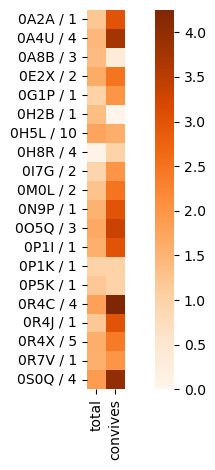

In [10]:
# On va calculer la moyenne des correlations entre les plateaux des amis et les plateaux des individus totaux. 
# Pour mieux faire apparaitre notre signal, il faut enlever les 'NaN' --> ceux qui ont mangé tous seuls et à qui 
# on a attribué la valeur Nan 

mean_tot = corr['corr_tot'].mean()
mean_convives = corr['corr_convives'].mean(skipna = True)
print(mean_tot, mean_convives)

table = corr[['corr_tot', 'corr_convives', 'individu', 'nb_copains']].dropna(how='any')

y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], cmap = 'Oranges',square=True,cbar = True, yticklabels= y_t[0:20] , xticklabels=['total', 'convives'])
#sns.heatmap(np.zeros(20).reshape(20,1), square = True, cbar = False, ax= ax1, cmap = 'binary', annot = np.array(table['nb_copains'][0:20]).reshape(20,1), xticklabels=['nb_copains'])


plt.tight_layout()
plt.show()
#plt.savefig('figures/corr_plateaux_global')

On observe qu'il y a effectivement une corrélation entre le plateau de l'individu et de ses amis plus forte que le plateau d'une personne et des autres individus lambda du meme jour. 

In [11]:
mean_tot_21 = corr_oct_21['corr_tot'].mean()
mean_convives_21 = corr_oct_21['corr_convives'].mean(skipna = True)
mean_tot_22 = corr_oct_22['corr_tot'].mean()
mean_convives_22 = corr_oct_22['corr_convives'].mean(skipna = True)
mean_tot_28 = corr_oct_28['corr_tot'].mean()
mean_convives_28 = corr_oct_28['corr_convives'].mean(skipna = True)
mean_tot_29 = corr_oct_29['corr_tot'].mean()
mean_convives_29 = corr_oct_29['corr_convives'].mean(skipna = True)

print('nombre de personnes avec lesquelles on calcule le produit scalaire : ')
print(len(corr_oct_21['corr_tot']), len(corr_oct_22['corr_tot']), len(corr_oct_28['corr_tot']), len(corr_oct_29['corr_tot']))
print('moyenne des produits scalaires avec autrui')
print(round(mean_tot_21, ndigits =2), round(mean_tot_22, ndigits =2), round(mean_tot_28, ndigits =2), round(mean_tot_29, ndigits =2))
print('moyenne des produits scalaires avec les convives')
print(round(mean_convives_21, ndigits =2), round(mean_convives_22, ndigits =2), round(mean_convives_28, ndigits =2), round(mean_convives_29, ndigits =2))

nombre de personnes avec lesquelles on calcule le produit scalaire : 
99 56 122 49
moyenne des produits scalaires avec autrui
1.23 1.3 1.31 1.09
moyenne des produits scalaires avec les convives
1.71 2.3 1.74 1.49


4.25


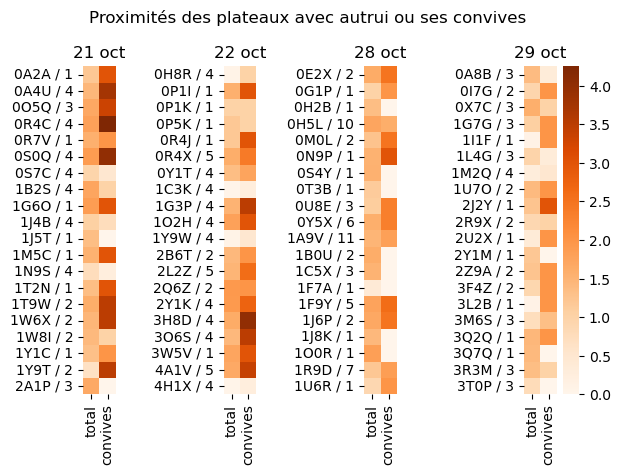

In [12]:
# on peut voir les résultats jour par jour :
mini = 0
maxi = max(max(corr_oct_21['corr_tot']), max(corr_oct_21['corr_convives']), max(corr_oct_22['corr_tot']), max(corr_oct_22['corr_convives']), max(corr_oct_28['corr_tot']), max(corr_oct_28['corr_convives']), max(corr_oct_29['corr_tot']), max(corr_oct_29['corr_convives']))
print(maxi)

plt.figure()
plt.suptitle('Proximités des plateaux avec autrui ou ses convives')

plt.subplot(141)
text = str(round(mean_tot_21, ndigits = 2)) + '/'+ str(round(mean_convives_21, ndigits = 2))
plt.title('21 oct')
table = corr_oct_21.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20],vmin=mini, vmax=maxi, cbar= False,  cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(142)
text = str(round(mean_tot_22, ndigits = 2)) + '/'+ str(round(mean_convives_22, ndigits = 2))
plt.title('22 oct')
table = corr_oct_22.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi,cbar= False, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(143)
text = str(round(mean_tot_28, ndigits = 2)) + '/'+ str(round(mean_convives_28, ndigits = 2))
plt.title('28 oct')
table = corr_oct_28.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi, cbar= False, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(144)
text = str(round(mean_tot_29, ndigits = 2)) + '/'+ str(round(mean_convives_29, ndigits = 2))
plt.title('29 oct')
table = corr_oct_29.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi, cbar= True, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.tight_layout()

plt.savefig('figures/corr_plateaux')

#### B - Avec l'ensembles des autres personnes les autres jours 

In [13]:
# Nous allons utiliser un nouveau fichier merged, qui lui représente les aliments sous forme de grande catégorie
# et non pas de manière continue 

merged_cat = pd.read_csv('../data_CROUS/data_processed/merged_one_hot/merged_Forms_Choix_regrmt_Hélène.csv' , sep=";", encoding='latin-1')
print(merged_cat.columns)
print(merged_cat.columns[40])

Index(['Unnamed: 0', 'index', 'Genre', 'Age', 'Taille', 'Poids', 'IMC',
       'Activité physique', 'Régime particulier', 'Végé', 'Fréquence CROUS',
       'Equilibre alim', 'Seule ou en groupe', 'Nb groupe entrée', 'Proximité',
       'Connaissance', 'Parti groupe', 'Influ sociale', 'Percept senso',
       'Nb file', 'Faim', 'Stress', 'Nb convives', 'Ami 1', 'Ami 2', 'Ami 3',
       'Ami 4', 'Ami 5', 'Ami 6', 'Ami 7', 'Ami 8', 'Ami 9', 'Ami 10',
       'Ami 11', 'Ami 12', 'Ami 13', 'Ami 14', 'Ami 15', 'Ami 16', 'Ami 17',
       'onehot_fruits', 'onehot_fromage', 'onehot_crudites',
       'onehot_saladefeculents', 'onehot_charcuterie', 'onehot_viande',
       'onehot_poisson', 'onehot_vege', 'onehot_yaourt',
       'onehot_dessertgourmand', 'onehot_cremedessert',
       'onehot_accompagnement'],
      dtype='object')
onehot_fruits


In [14]:
corr_cat = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])

for i, n_form in enumerate(merged_cat['index']):
    #print(n_form)

    # ------- On crée la liste de tous les amis de l'individu que l'on étudie ------------
    friends = []
    for colonne in ['Ami 1','Ami 2','Ami 3','Ami 4','Ami 5', 'Ami 6', 'Ami 7', 'Ami 8', 'Ami 9', 'Ami 10','Ami 11', 'Ami 12', 'Ami 13', 'Ami 14','Ami 15', 'Ami 16', 'Ami 17' ]:
        num_friend = merged_cat[colonne][i]
        if type(num_friend) == str:
            friends.append(num_friend)

    # ---- On calcule le produit scalaire entre le plateau de l'individu et celui de chacun de ses amis  ------------
    ps_convives = 0 # on initialise la somme du produit scalaire à 0 
    # plateau 1 est le plateau de l'individu étudié 
    plateau_1 = np.array(merged_cat.loc[merged_cat['index'] == n_form]).flatten()
    plateau_1 = plateau_1[40:] # on ne s'interesse qu'aux colonnes qui renseignent les plats 
    for ami in friends:
        if (merged_cat['index'] == ami).sum(): # si l'ami existe (= a bien rendu son formulaire )
            plateau_2 = np.array(merged_cat.loc[merged_cat['index'] == ami]).flatten() # le plateau de l'ami 
            plateau_2 = plateau_2[40:] # on ne s'interesse qu'aux colonnes renseignant les choix d'aliments
            ps_convives += np.dot(plateau_1, plateau_2.T)
        else : 
            friends.remove(ami)
    
    # -------- On normalise le cumul des produits scalaire par le nombre d'amis -------
    try:
        ps_convi_norm = ps_convives/len(friends)
    except:
        ps_convi_norm = np.nan # si l'individu  mangé seul (== len(friends) = 0)

    # ----------- On calcule le produit scalaire entre tous les plateaux (jours confondus) et celui de l'indiv étudié   ------------
    ps_tot = 0

    for indiv in merged_cat['index']:
        if indiv != n_form:
            try:
                plateau_2 = np.array(merged_cat.loc[merged_cat['index'] == indiv]).flatten()
                plateau_2 = plateau_2[40:]
                ps_tot += np.dot(plateau_1, plateau_2.T)

            except:
                pass # cas où le numero de formulaire de la personne n'est plus dans le df processed 
                    # --> il n'y a rien à calculer 

    # On rajoute la ligne 
    # print(n_form, ps_tot/len(merged), ps_convi_norm)
    corr_cat = pd.concat([corr_cat,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/(len(merged_cat)-1), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 


1.6084568192543653 1.6461398285508957


<AxesSubplot: >

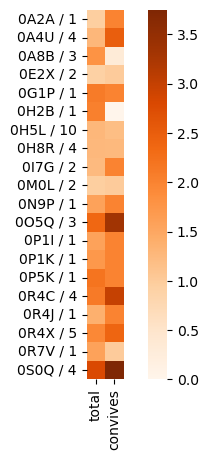

In [15]:
mean_tot_cat = corr_cat['corr_tot'].mean()
mean_convives_cat = corr_cat['corr_convives'].mean(skipna = True)
plt.figure()
print(mean_tot_cat, mean_convives_cat)
table = corr_cat.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])
#plt.savefig('figures/corr_plateaux_global_cat')

#### C - Cette influence n'est-elle pas juste due à l'horaire de passage ? 

In [16]:
# peut être les individus choisissent ils la même chose selon ce qui etait disponible à ce moment là ... 
# --> l'influence n'est pas celle des amis mais surtout de l'horaire de passage!! 

# nous allons calculer les corrélation entre plateaux, mais cette fois ci non pas avec 
# l'ensemble des personnes qui ont mangé ce jour la mais l'ensemble des personnes qui sont passées en même temps 
# au sein de 10 minutes (par ex) 

In [54]:
#print(merged.columns)
#print(merged['Horodateur'])
merged = pd.read_csv('../data_CROUS/data_processed/merged_one_hot/merged_Forms_Choix.csv' , sep=",", encoding='latin-1')
merged['Horodateur'] = merged['Horodateur'].replace(' ', '', regex = True)

# il y a des coquilles 
for i, item in enumerate(merged['Horodateur']):
    if len(item) == 9:
        #print(item) # on observe qu'un 3 s'est introduit dans les minutes 
        #print(item.remove(item[5]))
        item = item[:5] + item[6:]
        #merged['Horodateur'] = merged.loc[merged['Horodateur'][i]] = item
        merged.at[i, 'Horodateur'] = item
        #print(item)

#print([len(item) for item in merged['Horodateur']]) # toutes les longeurs sont à 8, on est bons :) 


In [87]:

merged['Horodateur'] = pd.to_datetime(merged['Horodateur'], format='%H:%M:%S')
#print(merged['Horodateur'])
# print("O2A4 est-il dans la colonne Individu ?", '02A4' in merged['index'].values)
# print("O2A4 est-il dans la colonne Individu ?", '0A4U' in merged['index'].values)
value1 = merged.loc[merged['index'] == '0A4U', 'Horodateur'].values[0]
value2 = merged.loc[merged['index'] == '0N9P', 'Horodateur'].values[0]
print(value1, value2)

print(value1 < value2)
print(value1 > value2)
#value_plus_5min = value + pd.Timedelta(minutes=5)
print(value1 -  pd.Timedelta(minutes=5) < value1 < value1 + pd.Timedelta(minutes=5) )

1900-01-01T13:12:52.000000000 1900-01-01T13:19:18.000000000
True
False
True


In [103]:
corrh = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains']) # h pour 'horodateur'

corrh_oct_21 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corrh_oct_22 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corrh_oct_28 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])
corrh_oct_29 = pd.DataFrame(columns = ['individu', 'corr_tot', 'corr_convives', 'nb_copains'])

for i, n_form in enumerate(merged['index']):
    #print(n_form)

    # ------- On crée la liste de tous les amis de l'individu que l'on étudie ------------
    friends = []
    for colonne in ['Ami 1','Ami 2','Ami 3','Ami 4','Ami 5', 'Ami 6', 'Ami 7', 'Ami 8', 'Ami 9', 'Ami 10','Ami 11', 'Ami 12', 'Ami 13', 'Ami 14', 'Ami 15', 'Ami 16', 'Ami 17' ]:
        num_friend = merged[colonne][i]
        if type(num_friend) == str:
            friends.append(num_friend)

    # ---- On calcule le produit scalaire entre le plateau de l'individu et celui de chacun de ses amis  ------------
    ps_convives = 0 # on initialise la somme du produit scalaire à 0 
    # plateau 1 est le plateau de l'individu étudié 
    plateau_1 = np.array(merged.loc[merged['index'] == n_form]).flatten()
    plateau_1 = plateau_1[41:] # on ne s'interesse qu'aux colonnes qui renseignent les plats 

    for ami in friends:
        if (merged['index'] == ami).sum(): # si l'ami existe (= a bien rendu son formulaire )
            plateau_2 = np.array(merged.loc[merged['index'] == ami]).flatten() # le plateau de l'ami 
            plateau_2 = plateau_2[41:] # on ne s'interesse qu'aux colonnes renseignant les choix d'aliments
            ps_convives += np.dot(plateau_1, plateau_2.T)
        else : 
            friends.remove(ami)
    
    # -------- On normalise le cumul des produits scalaire par le nombre d'amis -------
    try:
        ps_convi_norm = ps_convives/len(friends)
    except:
        ps_convi_norm = np.nan # si l'individu  mangé seul (== len(friends) = 0)

    # ----------- On calcule le produit scalaire entre tous les plateau DU MEME JOUR et celui de l'indiv étudié   ------------
    ps_tot = 0
    if n_form in nf_oct_21:
        jour = nf_oct_21
        #print('21 oct')
    if n_form in nf_oct_22:
        jour = nf_oct_22
        #print('22 oct')
    if n_form in nf_oct_28:
        jour = nf_oct_28
        #print('28 oct')
    if n_form in nf_oct_29:
        jour = nf_oct_29
        #print('29 oct')

    # la personne que l'on étudie a mangé à jour = jour 
    # on cherche parmi les personnes qui ont mangé ce jour la celles qui sont passées en meme temps que notre cas étudié
    
    cas_etudie_horaire = merged.loc[merged['index'] == n_form, 'Horodateur'].values[0]
    #print('len')
    #print(len(merged.loc[merged['index'] == n_form, 'Horodateur'].values))
    #print(cas_etudie_horaire)
    influenceurs = [] # la liste des individus qui ont mangé en meme temps que la personne étudiée, sans pour qutant que ce soit ses amis 
    
    for indiv in jour:# chaque individu de jour est un influenceur potentiel 
        try : 
            influenceur = merged.loc[merged['index'] == indiv]
            influenceur_horaire = merged.loc[merged['index'] == indiv, 'Horodateur'].values[0]

            if indiv != n_form:
                
                borne_min = influenceur_horaire - pd.Timedelta(minutes=5)
                borne_max = influenceur_horaire + pd.Timedelta(minutes=5)

                if  borne_min < cas_etudie_horaire < borne_max:  
                    plateau_2 = np.array(merged.loc[merged['index'] == indiv]).flatten()
                    plateau_2 = plateau_2[41:]
                    ps_tot += np.dot(plateau_1, plateau_2.T)
                    influenceurs.append(indiv)

        except:
            pass # cas où le numero de formulaire de la personne n'est plus dans le df processed # --> il n'y a rien à calculer 

    # Pour voir si il y a des choses particulières certain jours, on enregistre les valeurs 
    # corr_tot ici, ne contient pas la correlation avec l'ensemble des personne ayant mangé ce jour l) mais avec 
    # les personnes ayant mangé ce jour la dans les meme horaires que le case étudié 
    if jour == nf_oct_21:
        try: 
            corrh_oct_21 = pd.concat([corrh_oct_21,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(influenceurs), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
        except ZeroDivisionError:
            # dans le cas où personne n'a mangé en même temps que l'individu étudié, alors len(influenceurs) == 0 --> on donne une correlation à 0
            corrh_oct_21 = pd.concat([corrh_oct_21,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : None, 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])])
    
    if jour == nf_oct_22:
        try:
            corrh_oct_22 = pd.concat([corrh_oct_22,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(influenceurs), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
        except ZeroDivisionError:
            corrh_oct_22 = pd.concat([corrh_oct_22,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : None, 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    
    if jour == nf_oct_28:
        try:
            corrh_oct_28 = pd.concat([corrh_oct_28,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(influenceurs), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
        except ZeroDivisionError: 
            corrh_oct_28 = pd.concat([corrh_oct_28,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : None, 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    
    if jour == nf_oct_29:
        try: 
            corrh_oct_29 = pd.concat([corrh_oct_29,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(influenceurs), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
        except ZeroDivisionError:
            corrh_oct_29 = pd.concat([corrh_oct_29,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : None, 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    
    # On rajoute la ligne 
    # print(n_form, ps_tot/len(merged), ps_convi_norm)
    try : 
        corrh = pd.concat([corrh,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : ps_tot/len(influenceurs), 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 
    except ZeroDivisionError: 
        corrh = pd.concat([corrh,pd.DataFrame.from_records([{'individu' : n_form,'corr_tot' : None, 'corr_convives': ps_convi_norm, 'nb_copains' : len(friends)}])]) # on ajoute la ligne 


In [107]:
mean_tot_h_21 = corrh_oct_21['corr_tot'].mean(skipna = True)
mean_convives_21 = corrh_oct_21['corr_convives'].mean(skipna = True)
mean_tot_h_22 = corrh_oct_22['corr_tot'].mean(skipna = True)
mean_convives_22 = corrh_oct_22['corr_convives'].mean(skipna = True)
mean_tot_h_28 = corrh_oct_28['corr_tot'].mean(skipna = True)
mean_convives_28 = corrh_oct_28['corr_convives'].mean(skipna = True)
mean_tot_h_29 = corrh_oct_29['corr_tot'].mean(skipna = True)
mean_convives_29 = corrh_oct_29['corr_convives'].mean(skipna = True)

print('nombre de personnes avec lesquelles on calcule le produit scalaire : ')
print(len(corrh_oct_21['corr_tot']), len(corrh_oct_22['corr_tot']), len(corrh_oct_28['corr_tot']), len(corrh_oct_29['corr_tot']))
print('moyenne des produits scalaires avec autrui')
print(round(mean_tot_h_21, ndigits =2), round(mean_tot_h_22, ndigits =2), round(mean_tot_h_28, ndigits =2), round(mean_tot_h_29, ndigits =2))
print('moyenne des produits scalaires avec les convives')
print(round(mean_convives_21, ndigits =2), round(mean_convives_22, ndigits =2), round(mean_convives_28, ndigits =2), round(mean_convives_29, ndigits =2))

nombre de personnes avec lesquelles on calcule le produit scalaire : 
99 56 122 49
moyenne des produits scalaires avec autrui
1.82 1.81 1.84 1.59
moyenne des produits scalaires avec les convives
1.71 2.3 1.74 1.49


4.25


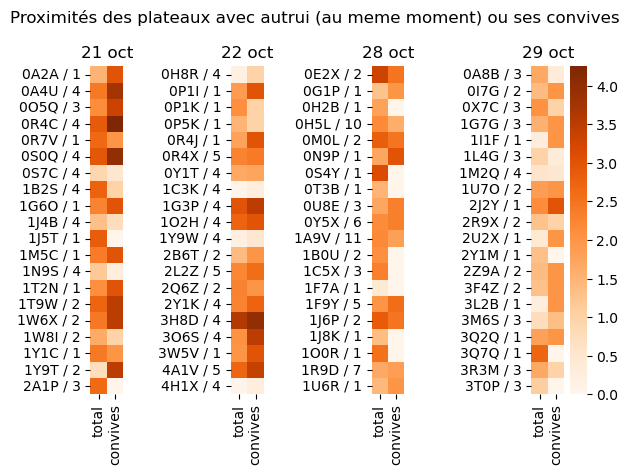

In [108]:
mini = 0
maxi = max(max(corrh_oct_21['corr_tot']), max(corrh_oct_21['corr_convives']), max(corrh_oct_22['corr_tot']), max(corrh_oct_22['corr_convives']), max(corrh_oct_28['corr_tot']), max(corrh_oct_28['corr_convives']), max(corrh_oct_29['corr_tot']), max(corrh_oct_29['corr_convives']))
print(maxi)

plt.figure()
plt.suptitle('Proximités des plateaux avec autrui (au meme moment) ou ses convives')

plt.subplot(141)
text = str(round(mean_tot_h_21, ndigits = 2)) + '/'+ str(round(mean_convives_21, ndigits = 2))
plt.title('21 oct')
table = corrh_oct_21.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20],vmin=mini, vmax=maxi, cbar= False,  cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(142)
text = str(round(mean_tot_h_22, ndigits = 2)) + '/'+ str(round(mean_convives_22, ndigits = 2))
plt.title('22 oct')
table = corrh_oct_22.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi,cbar= False, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(143)
text = str(round(mean_tot_h_28, ndigits = 2)) + '/'+ str(round(mean_convives_28, ndigits = 2))
plt.title('28 oct')
table = corrh_oct_28.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi, cbar= False, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.subplot(144)
text = str(round(mean_tot_h_29, ndigits = 2)) + '/'+ str(round(mean_convives_29, ndigits = 2))
plt.title('29 oct')
table = corrh_oct_29.dropna(how='any')
y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], vmin=mini, vmax=maxi, cbar= True, cmap = 'Oranges', square=True, yticklabels=y_t[0:20], xticklabels=['total', 'convives'])

plt.tight_layout()

#plt.savefig('figures/corr_plateaux_hotodatés')

1.7888845770394928 1.773242304467601


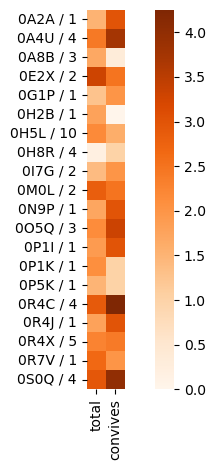

In [109]:
mean_tot_h = corrh['corr_tot'].mean(skipna = True)
mean_convives = corrh['corr_convives'].mean(skipna = True)
print(mean_tot_h, mean_convives)

table = corrh[['corr_tot', 'corr_convives', 'individu', 'nb_copains']].dropna(how='any')

y_t = [ (str(table.iloc[i]["individu"]) + ' / ' + str(int(table.iloc[i]["nb_copains"]))) for i in range(len(table['individu'])) ]
sns.heatmap(table[['corr_tot', 'corr_convives']][0:20], cmap = 'Oranges',square=True,cbar = True, yticklabels= y_t[0:20] , xticklabels=['total', 'convives'])
#sns.heatmap(np.zeros(20).reshape(20,1), square = True, cbar = False, ax= ax1, cmap = 'binary', annot = np.array(table['nb_copains'][0:20]).reshape(20,1), xticklabels=['nb_copains'])


plt.tight_layout()
plt.show()
#plt.savefig('figures/corr_plateaux_global')